# Football Forecasting - WDSS Demo [ Tidy Version ]

Here we provide a baseline model for our upcoming Premier League forecasting competition.

In [1]:
# Import some modules
from scipy.stats import poisson, skellam
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pandas as pd

In [2]:
# Import some more modules...
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Data

In [3]:
# Define a function to quickly get data from any given EPL season.
# N.B: Current GW fixtures are only added after the GW has finished.

def get_epl_data(season):
    """
    Takes in season formatted as YYYY (last 2 digits of Y1 and Y2 - no spaces or slashes)
    """
    x = pd.read_csv("http://www.football-data.co.uk/mmz4281/" + str(season) + "/E0.csv") # input season year within hyperlink
    
    x = x[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR']] # isolate required columns
    x = x.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals', 'FTR':'Result'})
    globals()["epl_"+str(season)] = x
    
    return globals()["epl_"+str(season)]

In [128]:
# Get data from the 2018/2019 season
# Consider COVID19's impact on home crowds and the home advantage - we will start with 18/19 instead
get_epl_data(2122)

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result
0,Brentford,Arsenal,2,0,H
1,Man United,Leeds,5,1,H
2,Burnley,Brighton,1,2,A
3,Chelsea,Crystal Palace,3,0,H
4,Everton,Southampton,3,1,H
5,Leicester,Wolves,1,0,H
6,Watford,Aston Villa,3,2,H
7,Norwich,Liverpool,0,3,A
8,Newcastle,West Ham,2,4,A
9,Tottenham,Man City,1,0,H


### Model

In [129]:
# Remove final week of fixtures
# Notice the home advantage
#epl_1819 = epl_1819[:-10]
epl_2122.mean()

HomeGoals    1.516667
AwayGoals    1.116667
dtype: float64

In [130]:
# probability of draw between home and away team
skellam.pmf(0.0,  epl_2122.mean()[0],  epl_2122.mean()[1])

0.2558121050065591

In [131]:
# Prepare the dataset
# Separate home and away teams/goals - then concatenate
goal_model_data = pd.concat([epl_2122[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl_2122[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

In [132]:
# Building the model
# Poisson Regression: log-linear model
poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

In [133]:
# Get a statistical summary of the poisson model
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  120
Model:                            GLM   Df Residuals:                       80
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -145.15
Date:                Wed, 29 Sep 2021   Deviance:                       86.444
Time:                        11:22:36   Pearson chi2:                     74.2
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.0427      0.617     -0.069      0.945      -1.251       1.166
team[T.Aston Villa]            0.3187      0.622      0.512      0.609      -0.901       1.539
team[T.Brentford]              0.6184      0.631      0.980      0.327      -0.619       1.856
team[T.Brighton]               0.0608      0.624      0.097      0.922      -1.163       1.284
team[T.Burnley]               -0.2582      0.680     -0.380      0.704      -1.590       1.074
team[T.Chelsea]                1.0908      0.583      1.872      0.061      -0.052       2.233
team[T.Crystal Palace]         0.3503      0.636      0.551      0.582      -0.896       1.597
team[T.Everton]                0.6451      0.555      1.162      0.245      -0.443       1.733
team[T.Leeds]                 -0.0652      0.658     -0.099      0.921      -1.355       1.225
team[T.Leicester]              0.3344      0.611      0.547      0.584      -0.864       1.533
team[T.Liverpool]              0.9996      0.537      1.861      0.063      -0.053       2.052
team[T.Man City]               0.6152      0.557      1.105      0.269      -0.476       1.706
team[T.Man United]             0.7026      0.585      1.201      0.230      -0.444       1.849
team[T.Newcastle]              0.0801      0.640      0.125      0.900      -1.175       1.335
team[T.Norwich]               -1.1991      0.883     -1.358      0.175      -2.930       0.532
team[T.Southampton]           -0.3261      0.729     -0.447      0.655      -1.756       1.104
team[T.Tottenham]             -0.1405      0.728     -0.193      0.847      -1.568       1.287
team[T.Watford]                0.1210      0.615      0.197      0.844      -1.084       1.326
team[T.West Ham]               0.6465      0.586      1.103      0.270      -0.502       1.795
team[T.Wolves]                -0.7457      0.764     -0.977      0.329      -2.242       0.751
opponent[T.Aston Villa]       -0.6101      0.519     -1.177      0.239      -1.626       0.406
opponent[T.Brentford]         -0.5855      0.609     -0.961      0.336      -1.779       0.608
opponent[T.Brighton]          -0.6621      0.581     -1.139      0.255      -1.801       0.477
opponent[T.Burnley]            0.0022      0.513      0.004      0.997      -1.002       1.007
opponent[T.Chelsea]           -1.6698      0.806     -2.071      0.038      -3.250      -0.090
opponent[T.Crystal Palace]    -0.4318      0.485     -0.890      0.373      -1.382       0.519
opponent[T.Everton]            0.1114      0.571      0.195      0.845      -1.008       1.230
opponent[T.Leeds]              0.1990      0.481      0.413      0.679      -0.745       1.143
opponent[T.Leicester]          0.3049      0.500      0.610      0.542      -0.675       1.285
opponent[T.Liverpool]         -0.8238      

### Simulation & Validation

In [276]:
# Build a function to simulate a match using the newly generated poisson model
# Outputs the probability distribution 
# Considers 8 goals as a maximum for either team

def simulate_match(homeTeam, awayTeam, max_goals=8, foot_model=poisson_model):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

# Test the function
simulate_match('Chelsea', 'Man City')

array([[4.58800224e-01, 1.53129896e-01, 2.55544394e-02, 2.84303018e-03,
        2.37223574e-04, 1.58352238e-05, 8.80864935e-07, 4.19998412e-08,
        1.75224176e-09],
       [2.04339896e-01, 6.82008104e-02, 1.13814057e-02, 1.26622539e-03,
        1.05654352e-04, 7.05267309e-06, 3.92318574e-07, 1.87058391e-08,
        7.80411346e-10],
       [4.55043296e-02, 1.51875978e-02, 2.53451845e-03, 2.81974976e-04,
        2.35281047e-05, 1.57055556e-06, 8.73651891e-08, 4.16559216e-09,
        1.73789337e-10],
       [6.75555468e-03, 2.25474473e-03, 3.76273601e-04, 4.18618928e-05,
        3.49297306e-06, 2.33164054e-07, 1.29702012e-08, 6.18422155e-10,
        2.58006959e-11],
       [7.52195221e-04, 2.51053879e-04, 4.18960719e-05, 4.66109997e-06,
        3.88924044e-07, 2.59615821e-08, 1.44416319e-09, 6.88580304e-11,
        2.87277078e-12],
       [6.70023620e-05, 2.23628154e-05, 3.73192450e-06, 4.15191029e-07,
        3.46437053e-08, 2.31254769e-09, 1.28639935e-10, 6.13358149e-12,
        2.5

In [135]:
# Similar function, selecting most probable scoreline

def simulate_match_output(homeTeam, awayTeam, max_goals=8, foot_model=poisson_model):
    # Predict avg goals
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    distribution = np.outer(np.array(team_pred[0]), np.array(team_pred[1])) # multiply distributions together
    
    # Get most likely score from the matrix
    global h, a
    h = np.argmax(distribution)//(max_goals + 1) 
    a = np.argmax(distribution)%(max_goals + 1) 
    output = homeTeam + ": " + str(h) + "\n" + awayTeam + ": " + str(a)
    
    return print(output)
    return(h, a)

simulate_match_output('Chelsea', 'Man City')

Chelsea: 0
Man City: 0


In [171]:
# Similar function, built to be iterated

def simulate_match_clean(homeTeam, awayTeam, max_goals=8, foot_model=poisson_model):
    # Predict avg goals
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    distribution = np.outer(np.array(team_pred[0]), np.array(team_pred[1])) # *multiply distributions together
    
    # Get most likely score
    global h, a
    h = np.argmax(distribution)//(max_goals + 1) 
    a = np.argmax(distribution)%(max_goals + 1) 
    
    return h, a

simulate_match_clean('Chelsea', 'Man City')

(0, 0)

In [314]:
# Simulate matches for any given PL seaason
# Takes in dataset as input

def simulate_test(x):
    
    data = x.copy()
    
    data['HomePred'] = [0] * len(data)
    data['AwayPred'] = [0] * len(data)
    
    for i in range(len(data)):
        homeTeam = data['HomeTeam'][i]
        awayTeam = data['AwayTeam'][i]
        
        simulate_match_clean(homeTeam, awayTeam)
        data.loc[i, 'HomePred'] = int(h)
        data.loc[i, 'AwayPred'] = int(a)
    
    data = pd.DataFrame.from_dict(data)
    
    return(data)

epl_2122_post = simulate_test(epl_2122)
epl_2122_post

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result,HomePred,AwayPred
0,Brentford,Arsenal,2,0,H,2,0
1,Man United,Leeds,5,1,H,3,0
2,Burnley,Brighton,1,2,A,0,1
3,Chelsea,Crystal Palace,3,0,H,2,0
4,Everton,Southampton,3,1,H,1,0
5,Leicester,Wolves,1,0,H,1,0
6,Watford,Aston Villa,3,2,H,0,2
7,Norwich,Liverpool,0,3,A,0,3
8,Newcastle,West Ham,2,4,A,1,2
9,Tottenham,Man City,1,0,H,0,1


In [271]:
# Add prediction results column

def update_df_result(data):
    # Binary array H=1 , notH = 0
    home_win = (data['HomePred']>data['AwayPred']).astype(int)
    # Binary array A=2 , notA = 0
    away_win = 2*(data['HomePred']<data['AwayPred']).astype(int)
    # Binary array D=2 , notD = 0
    draw = 3*(data['HomePred']==data['AwayPred']).astype(int)
    
    # Mapping 1,2,3 as 'H','A', 'D' respectively
    data['ResultPred'] = (home_win + away_win + draw).map({1:'H',
                                                           2:'A',
                                                           3:'D'})
    return data

In [272]:
# Add prediction results column

def update_df_ftr(data):

    correct = (data['ResultPred']==data['Result']).astype(int)
    incorrect = 2*(data['ResultPred']!=data['Result']).astype(int)
    
    # Mapping 1 & 2 as True & False respectively
    data['correctFTR'] = (correct + incorrect).map({1:True,
                                                           2:False,
                                                           })
    return data

In [313]:
# Vallidate Scoreline Prediction
# cs = correct score
# TWEAK*** printing NaN for correct scores instead of True

def update_df_cs(data):
    
    
    correct = ((data['HomeGoals']==data['HomePred']) & (data['AwayGoals']==data['AwayPred'])).astype(int)
    home = 2*(data['HomeGoals']==data['HomePred']).astype(int)
    away = 3*(data['AwayGoals'] == data['AwayPred']).astype(int)
    incorrect = 4*((data['HomeGoals']!=data['HomePred']) & (data['AwayGoals']!=data['AwayPred'])) .astype(int)
    
    # **Mapping 1 & 2 as True & False respectively
    data['correctScore'] = (correct + home + away + 
                            incorrect).map({1:True, 2:'H', 
                                             3:'A', 4: False})
    return data

In [319]:
# Update dataframe with validation

def update_df(data):
    
    update_df_res(data)
    update_df_ftr(data)
    update_df_cs(data)
    
    return data

In [332]:
update_df(epl_2122_post)

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result,HomePred,AwayPred,ResultPred,correctScore,correctFTR
0,Brentford,Arsenal,2,0,H,2,0,H,NaN,True
1,Man United,Leeds,5,1,H,3,0,H,False,True
2,Burnley,Brighton,1,2,A,0,1,A,False,True
3,Chelsea,Crystal Palace,3,0,H,2,0,H,A,True
4,Everton,Southampton,3,1,H,1,0,H,False,True
5,Leicester,Wolves,1,0,H,1,0,H,NaN,True
6,Watford,Aston Villa,3,2,H,0,2,A,A,False
7,Norwich,Liverpool,0,3,A,0,3,A,NaN,True
8,Newcastle,West Ham,2,4,A,1,2,A,False,True
9,Tottenham,Man City,1,0,H,0,1,A,False,False


In [322]:
# Total correct scorelines
epl_2122_post['correctScore'].value_counts()

False    20
A        16
H        13
Name: correctScore, dtype: int64

In [331]:
# Total correct final outcomes
epl_2122_post['correctFTR'].value_counts()

True     38
False    22
Name: correctFTR, dtype: int64

In [1]:
# Get percentage accuracy for outcomes
OutcomeAccuracy = round((epl_2122_post['correctFTR'].value_counts()[1]/sum(epl_2122_post['correctFTR'].value_counts()[:]))*100, 2)
OutcomeAccuracy

NameError: name 'epl_2122_post' is not defined

In [330]:
# At least one correct prediction (home, away or both)
sum(epl_2122_post['correctScore'].value_counts()[-3:])

49

### Plots

In [152]:
chelsea_mancity = simulate_match('Chelsea', 'Man City')

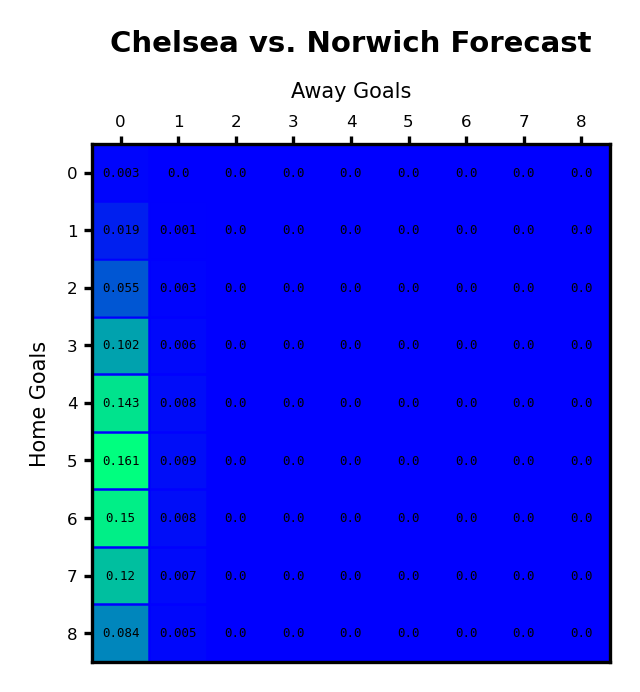

In [156]:
def goal_matrix(homeTeam, awayTeam):
    
    x = simulate_match(homeTeam, awayTeam)
    
    # *Match the plotting functions to the max goals
    # Axes labels
    goals = [0, 1, 2, 3, 4, 5, 6, 7, 8]

    # Plot figure
    fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
    fig.tight_layout()
    im = ax.imshow(x, cmap="winter")

    # Add grid
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(axis='both', which='minor', color='w', length=0)
    ax.grid(which="minor", color="b", linestyle='-', linewidth=0.6)  

    # Set ticks and paremeters
    ax.set_yticks(np.arange(len(goals)))
    ax.set_yticklabels(goals, fontsize=4)

    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(goals)))
    ax.set_xticklabels(goals, fontsize=4)

    ax.tick_params(axis='both', which='major', length=2, pad=1.5)

    ax.set_ylabel('Home Goals', fontsize=5) # axes label (y)
    ax.set_xlabel('Away Goals', fontsize=5)
    ax.xaxis.set_label_position('top')

    # * Set this to the Home vs Away teams
    ax.set_title(str(homeTeam) + " vs. " + str(awayTeam) + " Forecast",
                 fontsize=7, y=1.13, weight='bold')

    # *rename this variable
    # Rounding probabilites to add to the plot
    rounded = x.tolist()
    rounded3 = []
    for z in rounded:
        rounded2 = [round(x, 3) for x in z]
        rounded3.append(rounded2)
    rounded3 = np.array(rounded3)

    for i in range(len(goals)):
        for j in range(len(goals)):
            text = ax.text(j, i, rounded3[i, j],
                           ha="center", va="center", color="black", fontsize=3,
                           fontfamily='monospace')
    plt.savefig("test_graph.png")
    plt.show()
    
    
    
goal_matrix('Chelsea', 'Norwich')

In [28]:
# Define a function to get the seasons fixtures from csv
def get_epl_fixtures(season):
    """
    Takes in season formatted as YYYY (First Year of the season)
    """
    #x = pd.read_csv("https://fixturedownload.com/download/csv/epl-" + str(season)) # input season year within hyperlink
    x = pd.read_csv("https://fixturedownload.com/download/epl-" +str(season) + "-GMTStandardTime.csv") # input season year within hyperlink
    
    x = x[['Round Number','Home Team','Away Team','Result', 'Date']] # isolate required columns
    x = x.rename(columns={'Round Number': 'GW', 'Home Team': 'HomeTeam', 'Away Team':'AwayTeam'})
    globals()["epl_fixtures_"+str(season)] = x
    
    return globals()["epl_fixtures_"+str(season)]

In [29]:
get_epl_fixtures(2021)

,GW,HomeTeam,AwayTeam,Result,Date
0,1,Brentford,Arsenal,2 - 0,13/08/2021 20:00
1,1,Man Utd,Leeds,5 - 1,14/08/2021 12:30
2,1,Burnley,Brighton,1 - 2,14/08/2021 15:00
3,1,Chelsea,Crystal Palace,3 - 0,14/08/2021 15:00
4,1,Everton,Southampton,3 - 1,14/08/2021 15:00
...,...,...,...,...,...
375,38,Crystal Palace,Man Utd,NaN,22/05/2022 16:00
376,38,Leicester,Southampton,NaN,22/05/2022 16:00
377,38,Liverpool,Wolves,NaN,22/05/2022 16:00
378,38,Man City,Aston Villa,NaN,22/05/2022 16:00


In [93]:
# Get this weeks fixtures
gw = 7 # choose a GW
epl_fixtures_2021_new = epl_fixtures_2021.loc[epl_fixtures_2021['GW'] == gw]
epl_fixtures_2021_new = epl_fixtures_2021_new[["HomeTeam", "AwayTeam"]].replace({"Man Utd":"Man United", "Spurs":"Tottenham"})
epl_fixtures_2021_new

,HomeTeam,AwayTeam
60,Man United,Everton
61,Burnley,Norwich
62,Chelsea,Southampton
63,Leeds,Watford
64,Wolves,Newcastle
65,Brighton,Arsenal
66,Crystal Palace,Leicester
67,Tottenham,Aston Villa
68,West Ham,Brentford
69,Liverpool,Man City


#### Season Standings

https://www.rotowire.com//soccer/tables/standings.php?league=EPL&length=total&season=2019

https://www.rotowire.com/soccer/league-table.php?season=2018

In [ ]:
game_week = epl_fixtures_2021[50:60][:][['HomeTeam', 'AwayTeam']].reset_index()
game_week

In [106]:
home = epl_fixtures_2021_new['HomeTeam'].tolist()
away = epl_fixtures_2021_new['AwayTeam'].tolist()

In [176]:
scores = []

for i in range(len(home)):

    x = simulate_match_clean(home[i], away[i])
    
    
    scores.append(x)
    
scores[1][1]

0